# Linkage Disequilibrium Score

The LD score of a variant is a measure to describe how **connected or tagged this variant is with other variants** by summing up the squared correlation (r²) with every other variant under consideration.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide5.png)

# Key Formula

The LD score for a SNP is the sum of squared correlation $r^2$ measured with all other SNPs:

$$
l_j = \sum_{k=1, k \neq j}^M r^2(\textbf{X}_j, \textbf{X}_k)
$$

# Technical Details

## Definition and Calculation

The LD score for the $j$-th variant is defined as the sum of the squared correlation coefficients $r^2$ between that variant and all other variants in the genome, typically within a specified genomic window or region:

$$
l_j = \sum_{k=1, k \neq j}^M r^2_{i,k}
$$

However, this is not an unbiased estimate. We can correct for the bias like this:

$$
r_\text{adj}^2 =  \hat{r}^2 - \frac{1-\hat{r}^2}{N-2}
$$
$$
l_j = \sum_{k=1, k \neq j}^M  r_\text{adj}^2 
$$

## Interpretation: High LD Score and GWAS Signals

**What does a high LD score mean for GWAS results?** When a variant has high LD, any causal effect in the region gets "shared" across all correlated variants. If there's a true causal variant nearby, the marginal association signal will spread to all variants in LD with it. 

Therefore, **variants with higher LD scores are more likely to show inflated marginal association statistics** (larger |Z-scores|) even if they're not causal themselves. This is why LD score is useful for distinguishing true signals from LD-induced signals and for heritability estimation.

**Key insight**: LD score predicts how much a variant's marginal effect will be inflated by linkage to other causal variants.

### Effective number of SNPs

When there is LD between SNPs, it is useful to have a quantity that describes how many independent SNPs there are. This is the effective number of SNPs, markers or chromosome segments ($M_e$), and can be defined as

$$
M_{e} = \frac{M}{\bar{\boldsymbol{l}}} = \frac{M^2}{\sum_j l_j}
$$

where $\bar{\boldsymbol{l}}$ denotes the mean LD score across all SNPs.

# Related Topics

- [linkage disequilibrium](https://statfungen.github.io/statgen-primer/linkage_disequilibrium.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)

# Example

We've seen how genetic variants can be correlated with each other in [Lecture: linkage disequilibrium](https://statfungen.github.io/statgen-primer/linkage_disequilibrium.html), but how do we summarize the overall "connectedness" of each variant to all others? In statistical genetics, this is captured by the LD score - a single number that tells us how much linkage disequilibrium a variant has with all other variants in the region.

But there's a catch: with small sample sizes, the sample correlation is a biased estimator, meaning even unrelated variants can show non-zero correlations just due to sampling noise. How do we adjust for this bias, and what do LD scores look like before and after this adjustment?

In [1]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
 "CC", "CT", "AT",  # Individual 1
 "TT", "TT", "AA",  # Individual 2
 "CT", "CT", "AA",  # Individual 3
 "CC", "TT", "AA",  # Individual 4
 "CC", "CC", "TT"   # Individual 5
)
# Reshape into a matrix
N = 5
M = 3
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
  for (j in 1:M) {
    alleles <- strsplit(geno_matrix[i,j], "")[[1]]
    Xraw_additive[i,j] <- sum(alleles == alt_alleles[j])
  }
}

X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

# calculate the LD
R = cor(X)

The LD matrix is:

In [2]:
R

,Variant 1,Variant 2,Variant 3
Variant 1,1.0000000,-0.4677072,-0.562500
Variant 2,-0.4677072,1.0000000,0.868599
Variant 3,-0.5625000,0.8685990,1.000000


To calculate raw LD scores:
1. Sum squared correlations across each column
2. Subtract the diagonal (variant's correlation with itself)

This gives the total genetic connectivity for each variant.

In [3]:
R_sq = R^2
ld_scores_raw <- colSums(R_sq) - diag(R_sq)

The original LD scores are:

In [4]:
t(ld_scores_raw)

Variant 1,Variant 2,Variant 3
0.5351562,0.9732143,1.070871


We then adjust the LD scores:

In [5]:
R_squared_adj_mat = R_sq
# Apply the adjustment formula to each non-diagonal element
for (i in 1:M) {
  for (j in 1:M) {
#   Apply the adjustment formula: r2_adj = r2 - (1-r2)/(N-2)
    R_squared_adj_mat[i, j] <- R_sq[i, j] - (1 - R_sq[i, j]) / (N - 2)
  }
}
ld_scores_adjusted <- colSums(R_squared_adj_mat) - diag(R_squared_adj_mat)

The adjusted LD scores are:

In [6]:
t(ld_scores_adjusted)

Variant 1,Variant 2,Variant 3
0.046875,0.6309524,0.7611607


# Supplementary

## Graphical Summary

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


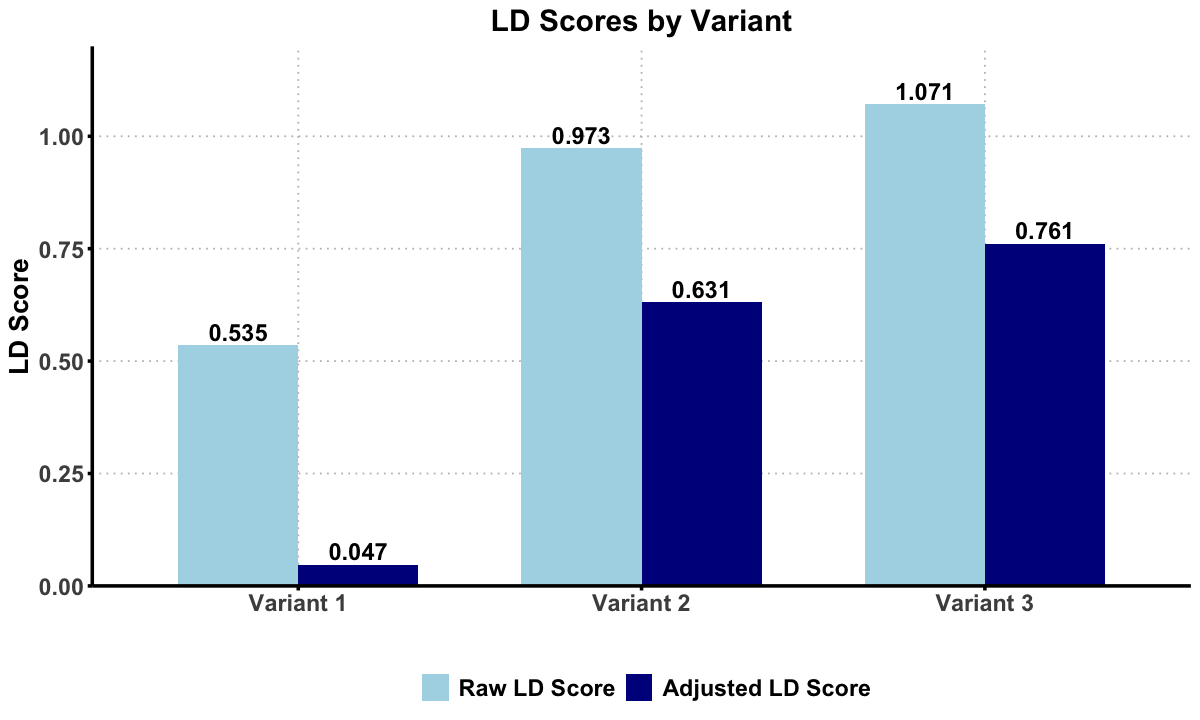

In [7]:
library(ggplot2)
library(reshape2)

# Set plot dimensions
options(repr.plot.width = 10, repr.plot.height = 6)

# Create a data frame with both raw and adjusted LD scores
ld_data <- data.frame(
  Variant = paste("Variant", 1:3),
  Raw_LD_Score = ld_scores_raw,
  Adjusted_LD_Score = ld_scores_adjusted
)

# Reshape data for ggplot
ld_long <- melt(ld_data, id.vars = "Variant", 
                variable.name = "Score_Type", value.name = "LD_Score")

# Create the plot
p <- ggplot(ld_long, aes(x = Variant, y = LD_Score, fill = Score_Type)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = sprintf("%.3f", LD_Score)), 
            position = position_dodge(width = 0.7), 
            vjust = -0.3, size = 5, fontface = "bold") +
  scale_fill_manual(values = c("Raw_LD_Score" = "lightblue", 
                              "Adjusted_LD_Score" = "darkblue"),
                   labels = c("Raw LD Score", "Adjusted LD Score")) +
  scale_y_continuous(limits = c(0, 1.2), breaks = c(0,0.25, 0.5, 0.75, 1), expand = c(0, 0)) +
  labs(title = "LD Scores by Variant",
       x = "",  # Remove x-axis title
       y = "LD Score",
       fill = "") +
  theme_minimal() +
  theme(
    text = element_text(size = 14, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 14, face = "bold"),
    legend.position = "bottom",  # Position legend at the bottom
    panel.grid.major = element_line(color = "gray", linetype = "dotted"),
    panel.grid.minor = element_blank(),
    axis.line = element_line(linewidth = 1),
    axis.ticks = element_line(size = 1),
    # Add transparent backgrounds
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

# Display the plot
print(p)

# Save with transparent background
ggsave("./cartoons/linkage_disequilibrium_scores.png", plot = p, 
       width = 10, height = 6, 
       bg = "transparent", 
       dpi = 300)